In [1]:
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
garstec_data = r'C:\Users\kiena\Documents\YEAR 4\PROJECT\Data\Garstec_AS09_chiara.hdf5'

# For this neural network we will try to use age as an input to output luminosity and effective temperature
ages = []
luminosities = []
temperatures = []

with h5py.File(garstec_data, 'r') as hdf:

# Navigate through Grid -> tracks -> trackxxxxx
    grid = hdf['grid']
    tracks = grid['tracks']

    # Access the data from each track
    for track_name in tracks:
        track = tracks[track_name]
        ages.extend(track['age'][:])
        luminosities.extend(track['LPhot'][:])
        temperatures.extend(track['Teff'][:])

# Convert lists to numpy arrays
ages = np.array(ages).reshape(-1, 1)    # reshape to 2d
luminosities = np.array(luminosities)
temperatures = np.array(temperatures)

outputs = np.column_stack((luminosities, temperatures))


In [3]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(ages, outputs, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train).view(-1, 1)
X_test = torch.FloatTensor(X_test).view(-1, 1)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

In [4]:
# Define the neural network, all dense layers
class GarstecNet(nn.Module):
    def __init__(self):
        super(GarstecNet, self).__init__()
        self.dense1 = nn.Linear(1, 32)   # Input layer
        self.dense2 = nn.Linear(32, 16) # Hidden layer
        self.dense3 = nn.Linear(16, 2) # Output layer for luminosity and temperature
        

    def forward(self, x):
        x = torch.relu(self.dense1(x))
        x = torch.relu(self.dense2(x))
        x = self.dense3(x)
        return x
    
# Instantiate model, loss function, and optimizer
model = GarstecNet()
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [5]:
num_epochs = 100

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode

    # Forward pass: Compute predicted outputs
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backward pass: Compute gradients and update weights
    optimizer.zero_grad()  # Clear gradients
    loss.backward()        # Backpropagation
    optimizer.step()       # Update weights

    # Print progress every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/100], Loss: 5646410.0000
Epoch [20/100], Loss: 4880893.5000
Epoch [30/100], Loss: 4608196.0000
Epoch [40/100], Loss: 4557537.0000
Epoch [50/100], Loss: 4543922.0000
Epoch [60/100], Loss: 4541881.5000
Epoch [70/100], Loss: 4540775.5000
Epoch [80/100], Loss: 4540048.0000
Epoch [90/100], Loss: 4539344.5000
Epoch [100/100], Loss: 4538686.0000


C:\Users\kiena\AppData\Local\Temp\ipykernel_9300\3617840660.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = model(torch.tensor(X_test, dtype=torch.float32)).numpy()
c:\Python310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


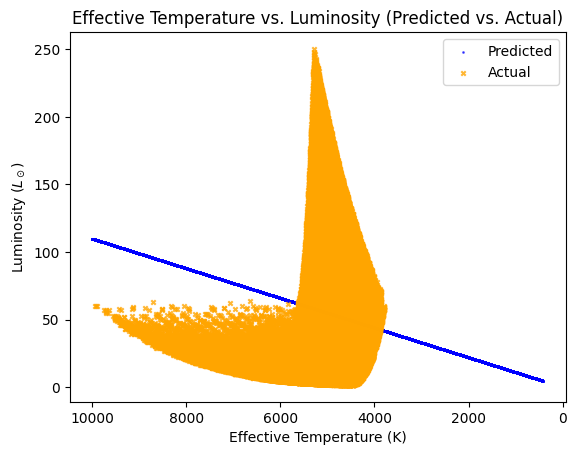

In [9]:
model.eval()
with torch.no_grad():
    # Make predictions on the test set
    predictions = model(torch.tensor(X_test, dtype=torch.float32)).numpy()

# Separate the predicted and actual values for each output (luminosity and temperature)
predicted_luminosity = predictions[:, 0]
predicted_temperature = predictions[:, 1]
actual_luminosity = y_test[:, 0]
actual_temperature = y_test[:, 1]

plt.scatter(predicted_temperature, predicted_luminosity, s=1, color='blue', alpha=0.6, label='Predicted')
plt.scatter(actual_temperature, actual_luminosity, s=10, color='orange', marker='x', alpha=0.8, label='Actual')
plt.gca().invert_xaxis()
plt.xlabel("Effective Temperature (K)")
plt.ylabel("Luminosity ($L_\odot$)")
plt.title("Effective Temperature vs. Luminosity (Predicted vs. Actual)")
plt.legend()
plt.show()
